In [8]:
# ===== System =====
import os
import glob


# ===== Core =====
import numpy as np
import cv2
import matplotlib.pyplot as plt


# ===== ML =====
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import joblib


# ===== Deep feature (offline only) =====
import tensorflow as tf
from keras.applications.vgg16 import VGG16, preprocess_input


# ===== Project modules =====
from dataset_lisa import build_patch_dataset_from_box_csvs
from features_hog import hog_batch
from skimage.feature import hog

In [9]:
DATASET_ROOT = r"C:/Users/PC/.cache/kagglehub/datasets/mbornoe/lisa-traffic-light-dataset/versions/2"


LABEL_MAP = {0: "other", 1: "green", 2: "red", 3: "yellow"}


RANDOM_SEED = 42
TEST_SIZE = 0.2
MAX_SAMPLES = 8000

In [10]:
print("Building dataset from LISA annotations...")
X_patches, y = build_patch_dataset_from_box_csvs(DATASET_ROOT, max_samples=MAX_SAMPLES)
print("Patches:", X_patches.shape)
print("Labels:", y.shape)

Building dataset from LISA annotations...
Patches: (8000, 64, 64, 3)
Labels: (8000,)


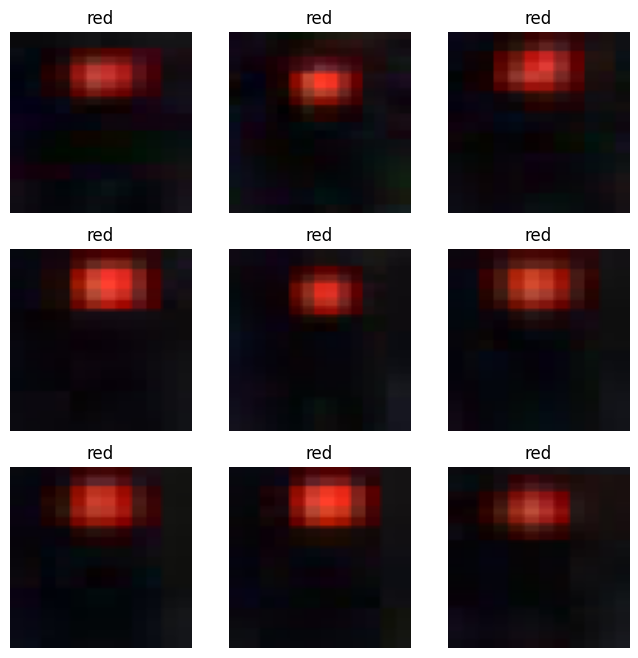

In [11]:
plt.figure(figsize=(8,8))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(X_patches[i])
    plt.title(LABEL_MAP[int(y[i])])
    plt.axis('off')
plt.show()

In [12]:
X_train_img, X_test_img, y_train, y_test = train_test_split(
    X_patches, y,
    test_size=TEST_SIZE,
    random_state=RANDOM_SEED,
    stratify=y
)
print("Train:", X_train_img.shape)
print("Test :", X_test_img.shape)

Train: (6400, 64, 64, 3)
Test : (1600, 64, 64, 3)


In [13]:
X_train_hog = hog_batch(X_train_img)
X_test_hog = hog_batch(X_test_img)
print("HOG train:", X_train_hog.shape)

HOG train: (6400, 5400)


In [14]:
svm_hog = make_pipeline(
StandardScaler(),
SVC(kernel='rbf', C=1.0, probability=True)
)


svm_hog.fit(X_train_hog, y_train)
pred_hog = svm_hog.predict(X_test_hog)


print("HOG Accuracy:", accuracy_score(y_test, pred_hog))
print(confusion_matrix(y_test, pred_hog))
print(classification_report(y_test, pred_hog))


joblib.dump(svm_hog, "outputs/svm_hog.joblib")

HOG Accuracy: 0.99625
[[942   2   0]
 [  3 595   0]
 [  0   1  57]]
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       944
           2       0.99      0.99      0.99       598
           3       1.00      0.98      0.99        58

    accuracy                           1.00      1600
   macro avg       1.00      0.99      0.99      1600
weighted avg       1.00      1.00      1.00      1600



['outputs/svm_hog.joblib']

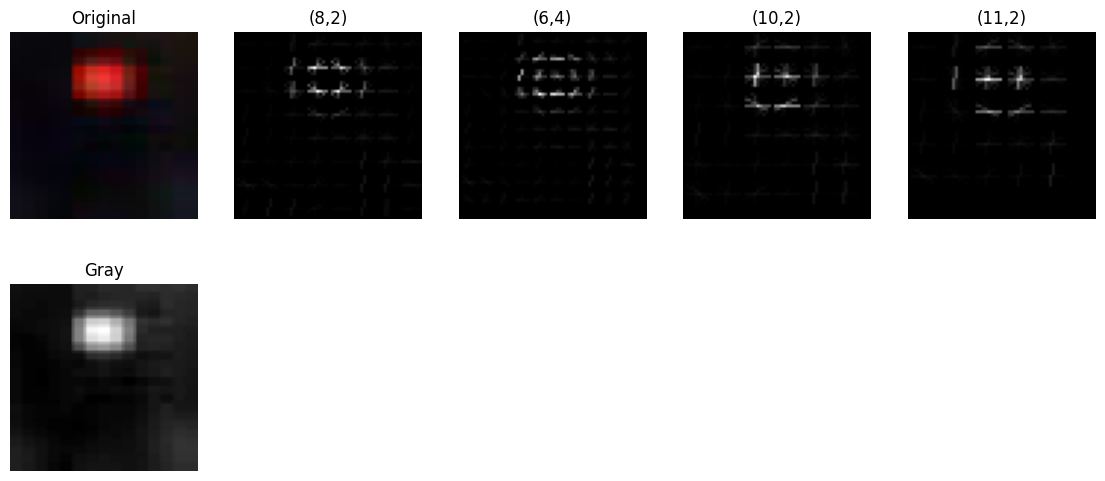

In [15]:
def visualize_hog_params(img_rgb):
    img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
    configs = [(8,2),(6,4),(10,2),(11,2)]


    plt.figure(figsize=(14,6))
    plt.subplot(2, len(configs)+1, 1)
    plt.imshow(img_rgb)
    plt.title("Original")
    plt.axis('off')


    plt.subplot(2, len(configs)+1, len(configs)+2)
    plt.imshow(img_gray, cmap='gray')
    plt.title("Gray")
    plt.axis('off')


    for i,(cell,block) in enumerate(configs):
        _, hog_img = hog(img_gray, orientations=9,
        pixels_per_cell=(cell,cell),
        cells_per_block=(block,block),
        visualize=True, block_norm='L2-Hys')
        plt.subplot(2, len(configs)+1, i+2)
        plt.imshow(hog_img, cmap='gray')
        plt.title(f"({cell},{block})")
        plt.axis('off')
    plt.show()


visualize_hog_params(X_patches[10])

In [16]:
base = VGG16(weights='imagenet', include_top=False, input_shape=(64,64,3))
base.trainable = False


vgg_extractor = tf.keras.Sequential([
base,
tf.keras.layers.GlobalAveragePooling2D()
])

X_train_vgg = vgg_extractor.predict(preprocess_input(X_train_img.astype('float32')), batch_size=64)
X_test_vgg = vgg_extractor.predict(preprocess_input(X_test_img.astype('float32')), batch_size=64)


svm_vgg = make_pipeline(
    StandardScaler(),
    SVC(kernel='rbf', C=1.0, probability=True)
)


svm_vgg.fit(X_train_vgg, y_train)
pred_vgg = svm_vgg.predict(X_test_vgg)


print("VGG Accuracy:", accuracy_score(y_test, pred_vgg))
print(confusion_matrix(y_test, pred_vgg))
print(classification_report(y_test, pred_vgg))

100/100 ━━━━━━━━━━━━━━━━━━━━ 49s 487ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 453ms/step
VGG Accuracy: 0.984375
[[944   0   0]
 [ 19 579   0]
 [  6   0  52]]
              precision    recall  f1-score   support

           1       0.97      1.00      0.99       944
           2       1.00      0.97      0.98       598
           3       1.00      0.90      0.95        58

    accuracy                           0.98      1600
   macro avg       0.99      0.95      0.97      1600
weighted avg       0.98      0.98      0.98      1600



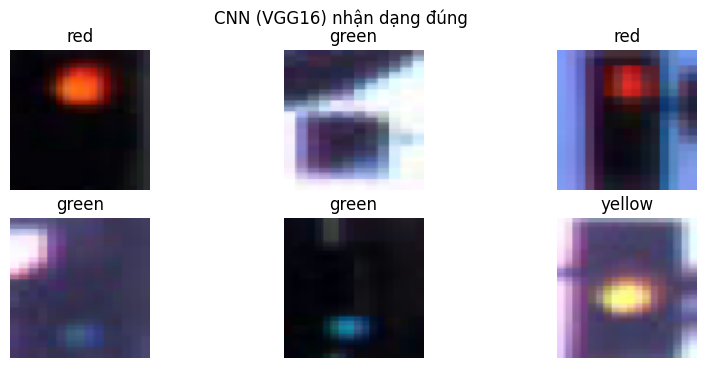

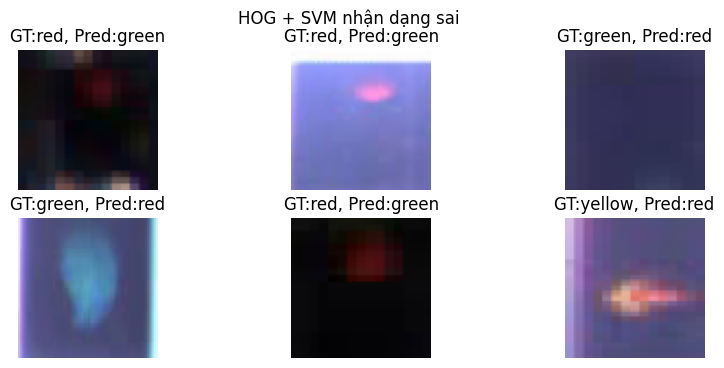

In [17]:
def show_correct(X, y, preds, title):
    idxs = np.where(preds == y)[0][:6]
    plt.figure(figsize=(10,4))
    for i,idx in enumerate(idxs):
        plt.subplot(2,3,i+1)
        plt.imshow(X[idx])
        plt.title(LABEL_MAP[y[idx]])
        plt.axis('off')
        plt.suptitle(title)
    plt.show()

def show_fail(X, y, preds, title):
    idxs = np.where(preds != y)[0][:6]
    plt.figure(figsize=(10,4))
    for i,idx in enumerate(idxs):
        plt.subplot(2,3,i+1)
        plt.imshow(X[idx])
        plt.title(f"GT:{LABEL_MAP[y[idx]]}, Pred:{LABEL_MAP[preds[idx]]}")
        plt.axis('off')
    plt.suptitle(title)
    plt.show()
    
show_correct(X_test_img, y_test, pred_vgg, "CNN (VGG16) nhận dạng đúng")
show_fail(X_test_img, y_test, pred_hog, "HOG + SVM nhận dạng sai")

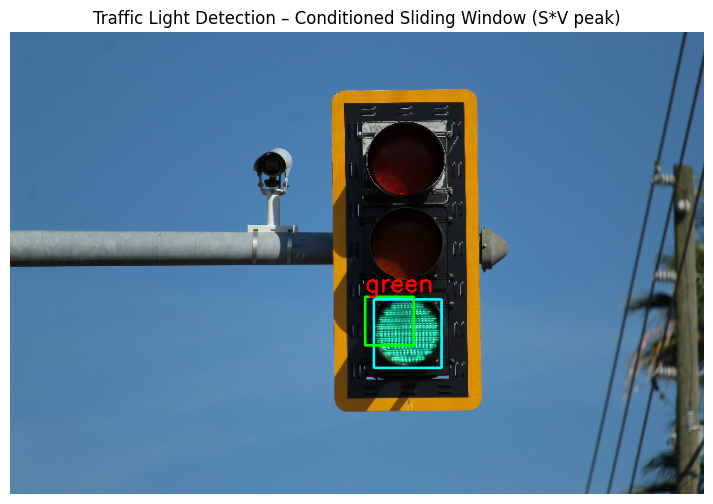

Chosen: green S= 176.0 V= 255.0 score= 41538.46484375 bbox= (419, 308, 78, 79, 4982)


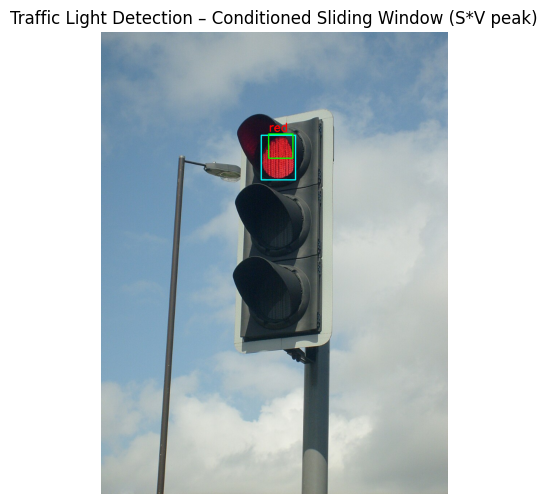

Chosen: red S= 215.0 V= 227.0 score= 44870.5 bbox= (369, 238, 79, 103, 6501)


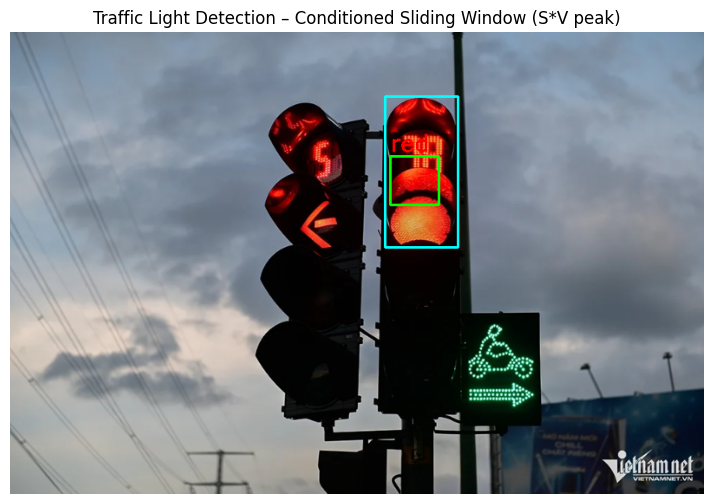

Chosen: red S= 255.0 V= 249.0 score= 62632.1640625 bbox= (432, 74, 84, 174, 10408)


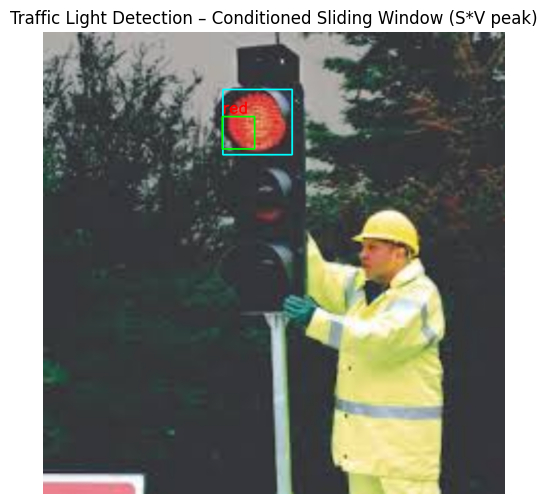

Chosen: red S= 205.0 V= 236.0 score= 46993.875 bbox= (311, 99, 120, 113, 10698)


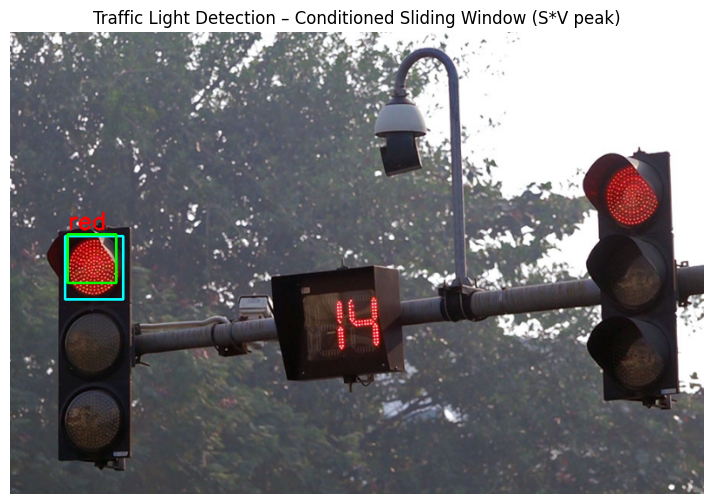

Chosen: red S= 215.0 V= 208.0 score= 43591.84375 bbox= (63, 235, 67, 73, 3848)


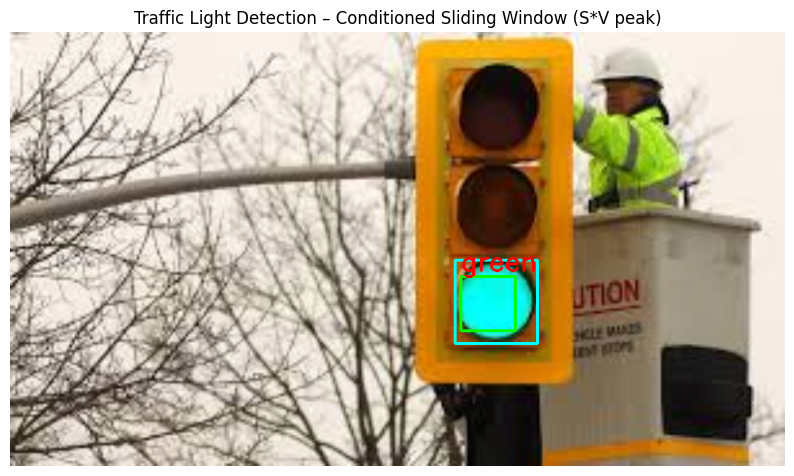

Chosen: green S= 254.0 V= 255.0 score= 64662.5546875 bbox= (459, 235, 85, 86, 6031)


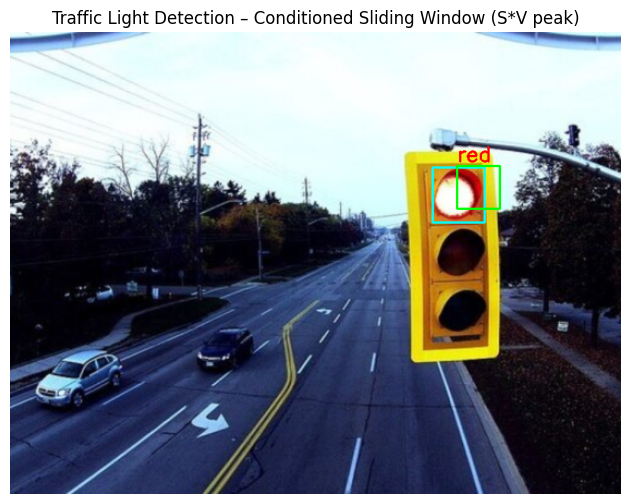

Chosen: red S= 248.0 V= 222.0 score= 51630.03515625 bbox= (553, 177, 68, 72, 2469)


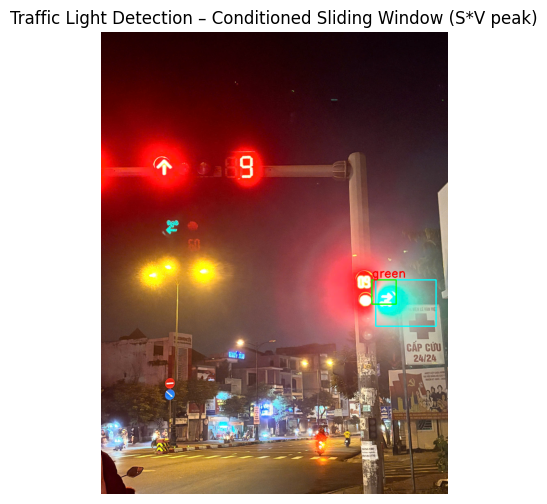

Chosen: green S= 255.0 V= 255.0 score= 64960.58984375 bbox= (633, 572, 139, 107, 10471)


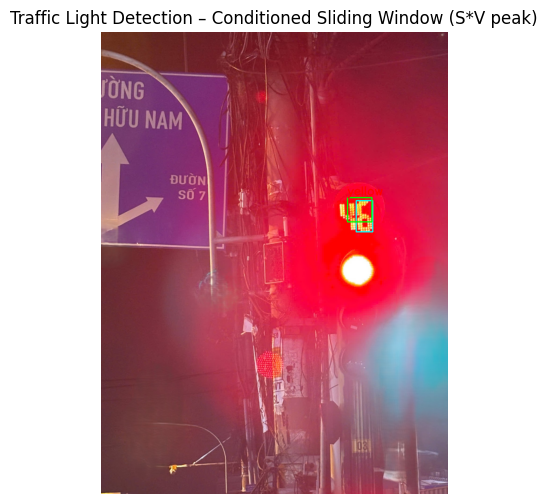

Chosen: yellow S= 245.0 V= 252.0 score= 54472.1953125 bbox= (588, 389, 38, 72, 1775)


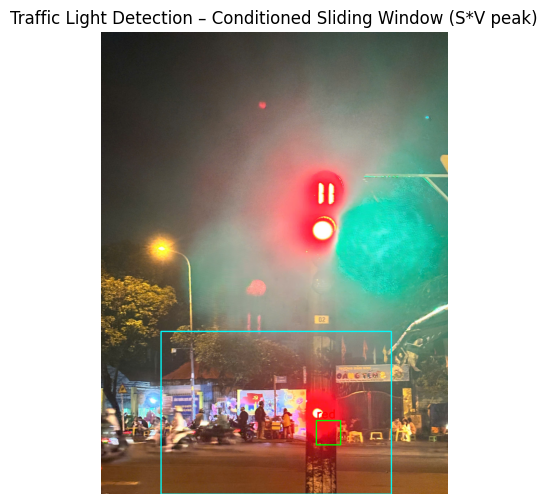

Chosen: red S= 242.0 V= 255.0 score= 36090.67265625 bbox= (138, 691, 531, 376, 103152)


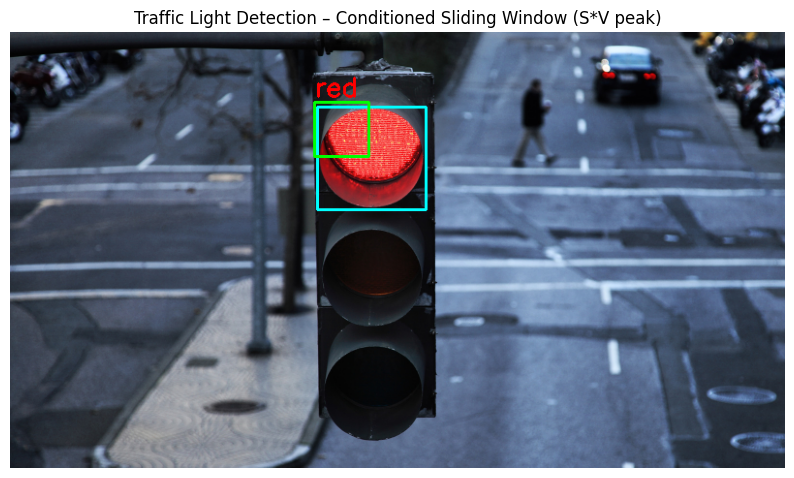

Chosen: red S= 170.0 V= 247.0 score= 46506.96484375 bbox= (317, 77, 112, 106, 9541)


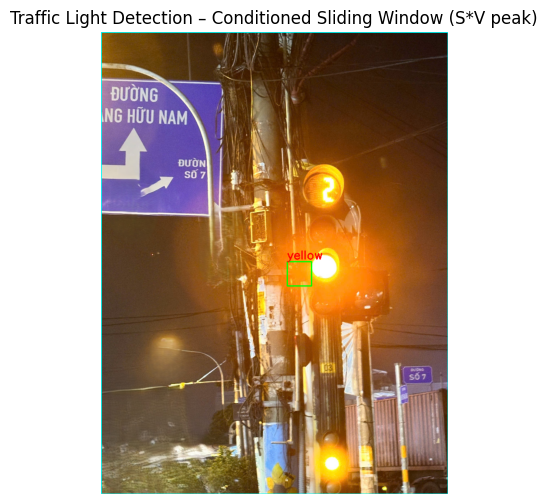

Chosen: yellow S= 255.0 V= 255.0 score= 39008.39296875 bbox= (0, 0, 800, 1067, 637588)


In [ ]:
# =========================
# FINAL STABLE DEMO (works in practice)
# Conditioned Sliding Window by "brightest colored pixel" (S*V)
# - Không cần threshold cứng kiểu v_abs_min/s_abs_min
# - Không phụ thuộc circularity/contour quá nhạy
# - Luôn ra box nếu trong ảnh có vùng màu đỏ/vàng/xanh đủ rõ
# =========================

import cv2
import numpy as np
import matplotlib.pyplot as plt

ID2NAME = {1: "green", 2: "red", 3: "yellow"}

def _make_hue_mask(hsv, color):
    H = hsv[..., 0]
    if color == "red":
        return ((H <= 10) | (H >= 160))
    if color == "yellow":
        return ((H >= 12) & (H <= 45))
    # green
    return ((H >= 35) & (H <= 95))

def _best_point_by_sv(hsv, hue_mask, y_top_ratio=0.92):
    """
    Chọn điểm mạnh nhất theo score = S*V trong vùng hue_mask.
    Có prior theo chiều dọc để tránh dính vùng dưới ảnh.
    """
    S = hsv[..., 1].astype(np.float32)
    V = hsv[..., 2].astype(np.float32)

    H, W = V.shape
    y_limit = int(H * y_top_ratio)

    # score map: S*V (0..65025)
    score = (S * V)
    score[~hue_mask] = 0.0
    score[y_limit:, :] = 0.0  # bỏ phần đáy ảnh để tránh kéo box lệch xuống

    # làm mượt để ổn định điểm peak
    score_blur = cv2.GaussianBlur(score, (0, 0), sigmaX=2.0)

    maxv = float(score_blur.max())
    if maxv <= 0:
        return None  # không có pixel nào hợp lệ

    y, x = np.unravel_index(np.argmax(score_blur), score_blur.shape)

    return (x, y, maxv, float(S[y, x]), float(V[y, x]))

def _bbox_from_cc(mask_bool, x, y):
    """
    Lấy bbox component chứa điểm (x,y) trong mask_bool.
    """
    m = (mask_bool.astype(np.uint8) * 255)
    kernel = np.ones((5, 5), np.uint8)
    m = cv2.morphologyEx(m, cv2.MORPH_OPEN, kernel)
    m = cv2.morphologyEx(m, cv2.MORPH_DILATE, kernel)

    num, labels, stats, _ = cv2.connectedComponentsWithStats((m > 0).astype(np.uint8), connectivity=8)
    if num <= 1:
        return None

    lab = labels[y, x]
    if lab == 0:
        return None

    x0, y0, w, h, area = stats[lab]
    return (int(x0), int(y0), int(w), int(h), int(area))

def demo_tl_conditioned_sw_svpeak(image_path, resize_w=640, win_size=48, debug=False):
    bgr = cv2.imread(image_path)
    if bgr is None:
        raise ValueError(f"Cannot read image: {image_path}")

    # resize
    scale = resize_w / bgr.shape[1]
    bgr = cv2.resize(bgr, None, fx=scale, fy=scale)

    hsv = cv2.cvtColor(bgr, cv2.COLOR_BGR2HSV)
    vis = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)

    # colors to check
    colors = [("red", 2), ("yellow", 3), ("green", 1)]

    best = None  # (score, cls, color_name, x,y, S,V, bbox)
    for cname, cls in colors:
        hm = _make_hue_mask(hsv, cname)

        # lọc nhẹ S/V để tránh sky noise nhưng KHÔNG quá chặt
        S = hsv[..., 1]
        V = hsv[..., 2]
        hm = hm & (S >= 40) & (V >= 40)

        pt = _best_point_by_sv(hsv, hm, y_top_ratio=0.92)
        if pt is None:
            continue

        x, y, sc, s_at, v_at = pt

        # bbox component quanh điểm peak
        bbox = _bbox_from_cc(hm, x, y)

        # nếu bbox quá to (dính khung) hoặc quá nhỏ, vẫn cho qua nhưng giảm điểm
        penalty = 0.0
        if bbox is not None:
            bx, by, bw, bh, barea = bbox
            img_area = vis.shape[0] * vis.shape[1]
            if barea > 0.03 * img_area:
                penalty += 0.4
            if barea < 60:
                penalty += 0.2

        final_score = sc * (1.0 - penalty)

        if (best is None) or (final_score > best[0]):
            best = (final_score, cls, cname, x, y, s_at, v_at, bbox)

    if best is None:
        plt.figure(figsize=(10, 6))
        plt.imshow(vis)
        plt.title("No colored peak found (try increase resize_w or relax S/V>=40)")
        plt.axis("off")
        plt.show()
        return

    final_score, cls, cname, x, y, s_at, v_at, bbox = best

    # sliding window đại diện quanh điểm peak
    xx = int(x - win_size // 2)
    yy = int(y - win_size // 2)
    xx = max(0, min(xx, vis.shape[1] - win_size))
    yy = max(0, min(yy, vis.shape[0] - win_size))

    # draw bbox component (cyan) nếu có
    if bbox is not None:
        bx, by, bw, bh, barea = bbox
        cv2.rectangle(vis, (bx, by), (bx + bw, by + bh), (0, 255, 255), 2)

    # draw sliding window (green)
    cv2.rectangle(vis, (xx, yy), (xx + win_size, yy + win_size), (0, 255, 0), 2)

    # label
    cv2.putText(
        vis,
        f"{ID2NAME[cls]}",
        (xx, max(0, yy - 6)),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.9,
        (255, 0, 0),
        2
    )

    # show
    plt.figure(figsize=(10, 6))
    plt.imshow(vis)
    plt.title("Traffic Light Detection – Conditioned Sliding Window (S*V peak)")
    plt.axis("off")
    plt.show()

    if debug:
        print("Chosen:", cname, "S=", s_at, "V=", v_at, "score=", final_score, "bbox=", bbox)


# RUN DEMO
demo_img = r"C:\Users\PC\models\eliobed-suarez-PN-YnI5stdQ-unsplash_e8ff418d-97fb-4e3c-a78c-8571b6b8e73b.jpg"
demo_tl_conditioned_sw_svpeak(demo_img, resize_w=800, win_size=56, debug=True)
demo_img = r"C:\Users\PC\models\Modern_British_LED_Traffic_Light.jpg"
demo_tl_conditioned_sw_svpeak(demo_img, resize_w=800, win_size=56, debug=True)
demo_img = r"C:\Users\PC\models\fdceb3c2065a4efa901855da21cd2ce3.webp"
demo_tl_conditioned_sw_svpeak(demo_img, resize_w=800, win_size=56, debug=True)
demo_img = r"C:\Users\PC\models\images.jpg"
demo_tl_conditioned_sw_svpeak(demo_img, resize_w=800, win_size=56, debug=True)
demo_img = r"C:\Users\PC\models\Den-Giao-Thong.jpg"
demo_tl_conditioned_sw_svpeak(demo_img, resize_w=800, win_size=56, debug=True)
demo_img = r"C:\Users\PC\models\images (1).jpg"
demo_tl_conditioned_sw_svpeak(demo_img, resize_w=800, win_size=56, debug=True)
demo_img = r"C:\Users\PC\models\fe4bbe81600a40063594e597e00eb05b_XL.jpg"
demo_tl_conditioned_sw_svpeak(demo_img, resize_w=800, win_size=56, debug=True)
demo_img = r"C:\Users\PC\models\z7324240416321_c76e55b65c04165983e9a37b3243f69c.jpg"
demo_tl_conditioned_sw_svpeak(demo_img, resize_w=800, win_size=56, debug=True)
demo_img = r"C:\Users\PC\models\z7324240433275_f8ca493d53ea3a8626c48fb20609b683.jpg"
demo_tl_conditioned_sw_svpeak(demo_img, resize_w=800, win_size=56, debug=True)
demo_img = r"C:\Users\PC\models\l-intro-1706556583.jpg"
demo_tl_conditioned_sw_svpeak(demo_img, resize_w=800, win_size=56, debug=True)
demo_img = r"C:\Users\PC\models\z7324240377872_311be3167050f8b7d46bea38b69af15d.jpg"
demo_tl_conditioned_sw_svpeak(demo_img, resize_w=800, win_size=56, debug=True)
